起手式，導入 numpy, matplotlib

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


下載 mnist 資料

In [2]:
import os
import urllib
dataset = 'mnist.pkl.gz'
def reporthook(a,b,c):
    print "\rdownloading: %5.1f%%"%(a*b*100.0/c),
    
if not os.path.isfile(dataset):
        origin = "https://github.com/mnielsen/neural-networks-and-deep-learning/raw/master/data/mnist.pkl.gz"
        print('Downloading data from %s' % origin)
        urllib.urlretrieve(origin, dataset, reporthook=reporthook)

載入訓練資料 `train_set`  和測試資料 `test_set`

In [3]:
import gzip
import pickle
with gzip.open(dataset, 'rb') as f:
            train_set, valid_set, test_set = pickle.load(f)

查看  mnist 資料的概況，用 `.shape` 看 np.array 的形狀

train_set 有五萬筆資料，第一部份是五萬筆長度為 784 的向量。第二部份是五萬個數字

test_set 則有一萬筆同樣形式的資料

In [4]:
print "train_set", train_set[0].shape, train_set[1].shape
print "valid_set", valid_set[0].shape, valid_set[1].shape
print "test_set", test_set[0].shape, test_set[1].shape

train_set (50000, 784) (50000,)
valid_set (10000, 784) (10000,)
test_set (10000, 784) (10000,)


資料的第一部份，每一筆都是一個 28x28 的圖片(28*28=784)

用 reshape 把長度784 的向量轉成 28*28 的方陣，就能當成圖片來看

下面是第一筆訓練資料的圖片

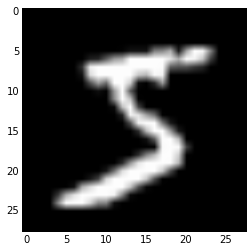

In [5]:
imshow(train_set[0][0].reshape((28, 28)), cmap="gray")

寫一個函數可以更方面的看圖。

我們查看前 5 筆資料，分別是 5張圖片，以及對應的 5 個數字

5
0
4
1
9


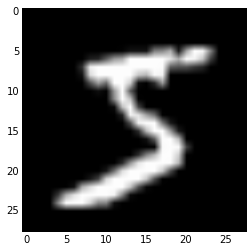

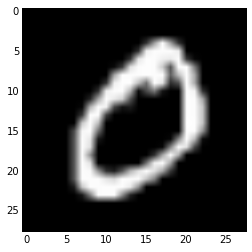

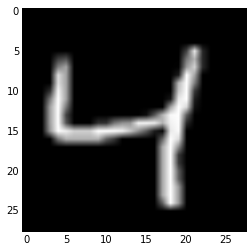

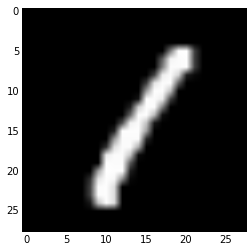

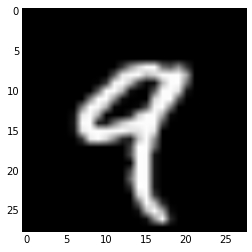

In [6]:
def show(x, i=[0]):
    plt.figure(i[0])
    imshow(x.reshape((28,28)), cmap="gray")
    i[0]+=1
for i in range(5):
    print train_set[1][i]
    show(train_set[0][i])

train_set 是用來訓練我們的模型用的

我們的模型是很簡單的 logistic regression 模型，用到的參數只有一個 784x10 的矩陣 W 和一個長度 10 的向量 b。

我們先用均勻隨機亂數來設定 W 和 b 。 

In [7]:
W = np.random.uniform(low=-1, high=1, size=(28*28,10))
b = np.random.uniform(low=-1, high=1, size=10)


完整的模型如下
將圖片看成是長度 784 的向量 x

計算 Wx+b， 然後再取 exp。 最後得到的十個數值。將這些數值除以他們的總和。
我們希望出來的數字會符合這張圖片是這個數字的機率。

# $softmax_i(W x + b)  = \frac {e^{W_i x + b_i}} {\sum_j e^{W_j x + b_j}}$


先拿第一筆資料試試看， x 是輸入。 y 是這張圖片對應到的數字(以這個例子來說 y=5)。

In [8]:
x = train_set[0][0]
y = train_set[1][0]

先計算 exp(Wx+b)

In [9]:
Pr = exp(dot(x, W)+b)
Pr.shape

(10,)

然後 normalize，讓總和變成 1 （符合機率的意義）

In [10]:
Pr = Pr/Pr.sum()
print Pr

[  5.43366229e-02   4.48098335e-02   5.45982193e-01   8.11663505e-02
   1.81669158e-03   2.41334332e-01   2.84695055e-03   1.59744634e-02
   5.90525375e-05   1.16735105e-02]


由於 W 和 b 都是隨機設定的，所以上面我們算出的機率也是隨機的。

如果照上面的機率來看，y=2 的機率有 54.5% 為最高。 y=5 的機率只有 24% （也不低，但只是運氣好）

為了要評斷我們的預測的品質，要設計一個評斷誤差的方式，我們用的方法如下（不是常見的方差，而是用熵的方式來算，好處是容易微分，效果好）



# $ error = - \log(P(Y=y^{(i)}|x^{(i)}, W,b)) $


上述的誤差評分方式，常常稱作 error 或者 loss，數學式可能有點費解。實際計算其實很簡單，就是下面的式子

In [11]:
loss = -log(Pr[y])
loss

1.421572037447159

目前的誤差 1.4215 不算太差，畢竟我們運氣很好，隨機的 W 和 b，居然能讓正確答案有 24% 的機率。

不過我們還是要想辦法改進。 我們用一種被稱作是 gradient descent 的方式來改善我們的誤差。

因為我們知道 gradient 是讓函數上升最快的方向。所以我們如果朝 gradient 的反方向走一點點（也就是下降最快的方向），那麼得到的函數值應該會小一點。

記得我們的變數是 W 和 b (裡面總共有 28*20+10 個變數)，所以我們要把 loss 對 W 和 b 裡面的每一個參數來偏微分。

還好這個偏微分是可以用手算出他的形式，而最後偏微分的式子也不會很複雜。

對 b 的偏微分如下

In [12]:
gradb = Pr.copy()
gradb[y] -= 1
print gradb

[  5.43366229e-02   4.48098335e-02   5.45982193e-01   8.11663505e-02
   1.81669158e-03  -7.58665668e-01   2.84695055e-03   1.59744634e-02
   5.90525375e-05   1.16735105e-02]


對 W 的偏微分也不難

In [13]:
print Pr.shape, x.shape, W.shape
gradW = dot(x.reshape(784,1), Pr.reshape(1,10), )
gradW[:, y] -= x

(10,) (784,) (784, 10)


算好 gradient 後，讓 W 和 b 分別往 gradient 反方向走一點點，得到新的 W 和 b

In [14]:
W -= 0.1 * gradW
b -= 0.1 * gradb

再一次計算 Pr 以及 loss

In [15]:
Pr = exp(dot(x, W)+b)
Pr = Pr/Pr.sum()
loss = -log(Pr[y])
loss

0.0005305630754095413

發現這次誤差下降到 0.0005 左右，改進不少


我們將同樣的方式輪流對五萬筆訓練資料來做，看看情形會如何

In [16]:
W = np.random.uniform(low=-1, high=1, size=(28*28,10))
b = np.random.uniform(low=-1, high=1, size=10)
score = 0
N=50000*20
d = 0.001
learning_rate = 1e-2
for i in xrange(N):
    if i%50000==0:
        print i, "%5.3f%%"%(score*100)
    x = train_set[0][i%50000]
    y = train_set[1][i%50000]
    Pr = exp(dot(x, W)+b)
    Pr = Pr/Pr.sum()
    loss = -log(Pr[y])
    score *=(1-d)
    if Pr.argmax() == y:
        score += d
    gradb = Pr.copy()
    gradb[y] -= 1
    gradW = dot(x.reshape(784,1), Pr.reshape(1,10), )
    gradW[:, y] -= x
    W -= learning_rate * gradW
    b -= learning_rate * gradb
    

0 0.000%
50000 88.066%
100000 89.229%
150000 89.972%
200000 90.455%
250000 90.704%
300000 91.078%
350000 91.028%
400000 91.165%
450000 91.279%
500000 91.347%
550000 91.548%
600000 91.547%
650000 91.732%
700000 91.738%
750000 91.826%
800000 91.767%
850000 91.854%
900000 91.897%
950000 92.024%
1000000 92.085%
1050000 92.086%
1100000 92.184%
1150000 92.253%
1200000 92.256%
1250000 92.318%
1300000 92.351%
1350000 92.379%
1400000 92.379%
1450000 92.427%


結果發現正確率大約是 92.42%， 但這是對訓練資料而不是對測試資料

而且，一筆一筆的訓練資也有點慢，線性代數的特點就是能夠向量運算。如果把很多筆 x 當成列向量組合成一個矩陣（然後還是叫做 x），由於矩陣乘法的原理，我們還是一樣計算 Wx+b ， 就可以同時得到多筆結果。

下面的函數，可以一次輸入多筆 x， 同時一次計算多筆 x 的結果和準確率。

In [17]:
def compute_Pr(x):
    Pr = exp(dot(x, W)+b)
    return Pr/Pr.sum(axis=1, keepdims=True)
def compute_accuracy(Pr, y):
    return mean(Pr.argmax(axis=1)==y)
    
    

下面是更新過得訓練過程， 當 i%100000 時，順便計算一下 test accuracy 和 valid accuracy。

In [18]:
W = np.random.uniform(low=-1, high=1, size=(28*28,10))
b = np.random.uniform(low=-1, high=1, size=10)
score = 0
N=50000*100
batch_size = 500
learning_rate = .7
for i in xrange(0, N, batch_size):
    if i%100000==0:
        x, y  = test_set[0], test_set[1]
        test_score = compute_accuracy(compute_Pr(x), y)*100
        x, y = valid_set[0], valid_set[1]
        valid_score = compute_accuracy(compute_Pr(x), y)*100
        print i, "%5.2f%%"%test_score, "%5.2f%%"%valid_score
    # 隨機選出一些訓練資料出來
    rndidx = np.random.choice(train_set[0].shape[0], batch_size, replace=False)
    x, y  = train_set[0][rndidx], train_set[1][rndidx]
    # 一次計算所有的 Pr
    Pr = compute_Pr(x)
    # 計算平均 gradient 
    gradb = Pr.mean(axis=0)-[(y==i).mean() for i in range(10)]
    gradW = dot(x.T, Pr)
    for i in range(batch_size):
        gradW[:, y[i]]-=x[i]
    gradW /= batch_size
    # 更新 W 和 b
    W -= learning_rate * gradW
    b -= learning_rate * gradb

0 11.35% 10.88%
100000 86.21% 86.89%
200000 88.46% 88.85%
300000 89.54% 89.92%
400000 90.08% 90.41%
500000 90.39% 90.60%
600000 90.77% 91.02%
700000 90.81% 91.24%
800000 91.08% 91.33%
900000 91.20% 91.28%
1000000 91.30% 91.56%
1100000 91.62% 91.63%
1200000 91.48% 91.65%
1300000 91.51% 91.76%
1400000 91.50% 92.05%
1500000 91.64% 91.86%
1600000 91.74% 92.06%
1700000 91.86% 92.21%
1800000 91.89% 92.11%
1900000 91.85% 92.07%
2000000 91.81% 92.12%
2100000 91.75% 92.10%
2200000 91.89% 92.35%
2300000 91.82% 92.25%
2400000 91.85% 92.17%
2500000 91.88% 92.23%
2600000 91.85% 92.33%
2700000 92.12% 92.31%
2800000 92.03% 92.34%
2900000 91.95% 92.50%
3000000 92.00% 92.44%
3100000 92.04% 92.45%
3200000 92.08% 92.35%
3300000 91.93% 92.59%
3400000 92.19% 92.43%
3500000 92.00% 92.41%
3600000 92.00% 92.49%
3700000 92.19% 92.39%
3800000 92.10% 92.62%
3900000 92.23% 92.53%
4000000 92.05% 92.40%
4100000 92.23% 92.54%
4200000 92.20% 92.59%
4300000 92.25% 92.72%
4400000 92.30% 92.71%
4500000 92.19% 92.62%
460

最後得到的準確率是 92%-93%

不算完美，不過畢竟這只有一個矩陣而已。

In [19]:
x, y  = test_set[0], test_set[1]
Pr = compute_Pr(x)
test_score = compute_accuracy(Pr, y)*100
x, y = valid_set[0], valid_set[1]
Pr = compute_Pr(x)
valid_score = compute_accuracy(Pr, y)*100
print "test accuracy %5.2f%%"%test_score, "valid accuracy %5.2f%%"%valid_score
x, y = train_set[0], train_set[1]
Pr = compute_Pr(x)
train_score = compute_accuracy(Pr, y)*100
print "train accuracy %5.2f%%"%train_score

test accuracy 92.28% valid accuracy 92.69%
train accuracy 93.16%


光看數據沒感覺，我們來看看前十筆測試資料跑起來的情形

可以看到前十筆只有錯一個

[7 2 1 0 4 1 4 9 6 9]
[7 2 1 0 4 1 4 9 5 9]


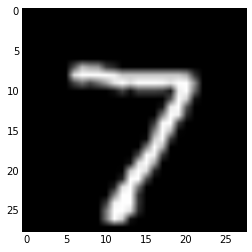

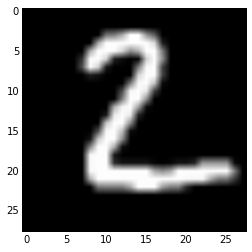

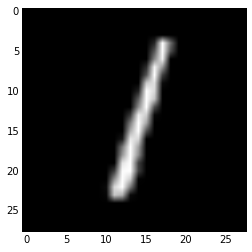

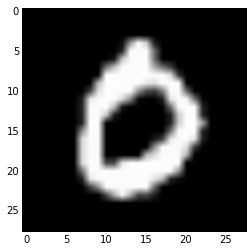

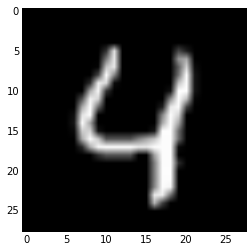

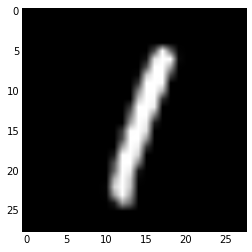

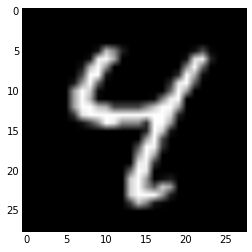

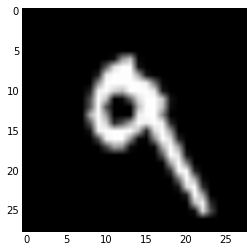

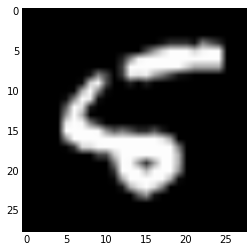

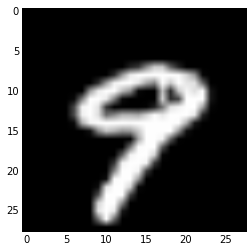

In [20]:
x = test_set[0][:10]
y = test_set[1][:10]
Pr = compute_Pr(x)
print Pr.argmax(axis=1)
print y
for i in range(10):
    show(x[i])

看看前一百筆資料中，是哪些情況算錯

6 5
6 4
2 3
7 6


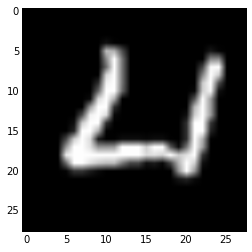

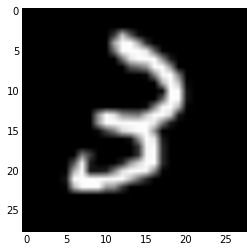

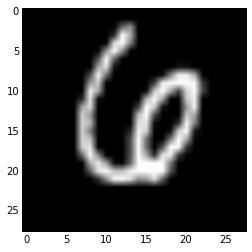

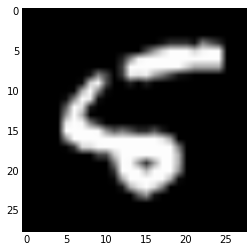

In [21]:
x = test_set[0][:100]
y = test_set[1][:100]
Pr = compute_Pr(x)
y2 = Pr.argmax(axis=1)
for i in range(100):
    if y2[i] != y[i]:
        print y2[i], y[i]
        show(x[i])